Things changed:  
1. sys.argv
2. list break
3. retina

In [1]:
import warnings
warnings.filterwarnings('ignore')

from timeit import default_timer as timer
import utils
import os
import glob
import pickle
import joblib
import sys
import matplotlib
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
import tkinter

In [7]:
%config InlineBackend.figure_format = 'retina'

##########################################################
# 1. Initialization
##########################################################

In [4]:
##########################################################
# 1. Initialization
##########################################################
# Arguments
downsample_ratio = 10
window_size = 100
predict_size = 25
normal_folder = 'ryerson_train'
anomaly_folder = 'ryerson_ab_train_LOS-5M-USRP1'
shift_eval = 125
batch_size = 128
gpu_no = 0

# downsample_ratio = int(sys.argv[1])
# window_size = int(sys.argv[2])
# predict_size = int(sys.argv[3])
# normal_folder = str(sys.argv[4])  # e.g. ryerson
# anomaly_folder = str(sys.argv[5])  # e.g. 0208_anomaly
# shift_eval = int(sys.argv[6])
# batch_size = int(sys.argv[7])
# gpu_no = int(sys.argv[8])

# Set gpu environment
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_no)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[gpu_no], 'GPU')
logical_devices = tf.config.experimental.list_logical_devices('GPU')

# String variables
downsample_str = 'downsample_' + str(downsample_ratio)
window_predict_size = str(window_size) + '_' + str(predict_size)

# General path
path = '/net/adv_spectrum/data/'

# Path to read featurized txt
abnormal_output_path = path + 'feature/{}/abnormal/{}/{}/'\
                    .format(downsample_str, anomaly_folder, window_predict_size)

# Path to save model and full_x_valid
full_x_valid_path = '/net/adv_spectrum/result/x_valid/'
full_x_valid_filename = full_x_valid_path + 'full_x_valid_{}_{}_{}.pkl'\
                        .format(downsample_str,
                                normal_folder,
                                window_predict_size)
model_path = '/net/adv_spectrum/model/{}/{}/'\
             .format(downsample_str, normal_folder)
model_filename = model_path + '{}_{}.h5'\
                 .format(downsample_ratio, window_predict_size)
model_info_filename = model_path + '{}_{}_{}_info.txt'\
                      .format(anomaly_folder,
                              downsample_ratio,
                              window_predict_size)
model_size = os.path.getsize(model_filename)

# Path to save valid error df and list of anomaly error df
valid_error_df_path = '/net/adv_spectrum/result/error_df/valid/' \
                      '{}/{}/'.format(downsample_str, normal_folder)
valid_error_df_filename = valid_error_df_path + 'valid_error_df_{}_{}.pkl'\
                          .format(normal_folder, window_predict_size)

anom_error_df_list_path = '/net/adv_spectrum/result/error_df/anomaly/' \
                          '{}/{}/'.format(downsample_str, anomaly_folder)
anom_error_df_list_filename = anom_error_df_list_path + \
                              'anom_error_df_{}_{}.pkl'\
                              .format(normal_folder, window_predict_size)

# Path of figure
figure_name = '[Anomaly v.s. Valid] CDF Plot for Prediction Error ' \
              '(ds_ratio={}, w_p_size={})'\
              .format(downsample_ratio, window_predict_size)
figure_path = '/net/adv_spectrum/result/plot/'
figure_filename = figure_path + 'CDF_plot_{}_{}_{}_{}.png'\
                  .format(normal_folder,
                          anomaly_folder,
                          downsample_ratio,
                          window_predict_size)

# Check path existence
if not os.path.exists(full_x_valid_path):
    os.makedirs(full_x_valid_path)
if not os.path.exists(valid_error_df_path):
    os.makedirs(valid_error_df_path)
if not os.path.exists(anom_error_df_list_path):
    os.makedirs(anom_error_df_list_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

##########################################################
# 2. Load Model and Data
##########################################################

In [5]:
model = tf.keras.models.load_model(model_filename)

# Change the path if you need other abnormal series. Be sure the series are
# stored in a format of list of arrays (shape = [n, 128]).
abnormal_series_list = []

print('Start retrieving abnormal series....')
for filename in sorted(glob.glob(abnormal_output_path + '*.txt')):
    print(filename)
    series = utils.txt_to_series(filename)
    abnormal_series_list.append(series)
    break

# Comment out the following operation if you do not need validation data
with open(full_x_valid_filename, 'rb') as f:
    full_x_valid = joblib.load(f)

Start retrieving abnormal series....
/net/adv_spectrum/data/feature/downsample_10/abnormal/ryerson_ab_train_LOS-5M-USRP1/100_25/feature_1518561613_1580685308_880M_5m_ap.txt


# Comment out the next section if you do not need validation data
##########################################################
# 3. Construct MSE DataFrame for Validation Data
##########################################################

In [44]:
print('Start constructing mse DataFrame...')
# Get valid_hat and evaluate time
start = timer()
valid_hat = utils.model_forecast(model, full_x_valid, batch_size, window_size,
                                 predict_size, shift_eval)
end = timer()
validation_time = (start - end) / (len(full_x_valid) // shift_eval)
print('Validation spends {} seconds! Hmm...'.format(validation_time))

# Get valid true
valid_hat_dim = np.shape(valid_hat)[0]
valid_true = np.reshape(utils.windowed_true(full_x_valid, shift_eval, predict_size), (-1, predict_size, 128))

# Create mse DataFrame
valid_mse = np.mean(np.power(valid_hat - valid_true[:valid_hat_dim], 2), axis=(1, 2))
valid_error_df = pd.DataFrame({'valid_error': valid_mse})

# Save MSE DataFrame
valid_error_df.to_pickle(valid_error_df_filename)

Start constructing mse DataFrame...
Validation spends -0.0004774024304677469 seconds! Hmm...


##########################################################
# 4. Construct Abnormal MSE
##########################################################

In [45]:
# Construct MSE DataFrame
anom_hat_list = [utils.model_forecast(model, i, batch_size, window_size,
                                      predict_size, shift_eval)
                 for i in abnormal_series_list]
anom_true_list = [utils.windowed_true(i, shift_eval, predict_size)
                  for i in abnormal_series_list]

anom_error_df_list = []

for i in range(len(anom_hat_list)):
    anom_hat = anom_hat_list[i]
    anom_hat_dim = np.shape(anom_hat)[0]
    anom_true = np.reshape(anom_true_list[i], (-1, predict_size, 128))

    anom_mse = np.mean(np.power(anom_hat - anom_true[:anom_hat_dim], 2), axis=(1, 2))
    anom_error_df = pd.DataFrame({'anom_error ' + str(i): anom_mse})
    anom_error_df_list.append(anom_error_df)

# Save MSE DataFrame
# with open(anom_error_df_list_filename, 'wb') as f:
#     pickle.dump(anom_error_df_list, f)

In [53]:
cut95 = valid_error_df.quantile(0.95)[0]

In [61]:
TP_df = anom_error_df[anom_error_df['anom_error 0'] > cut95]

In [62]:
FN_df = anom_error_df[anom_error_df['anom_error 0'] <= cut95]

In [63]:
TP_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248],
           dtype='int64', length=1241)

In [64]:
FN_df.index

Int64Index([105, 114, 120, 139, 602, 609, 617, 1215], dtype='int64')

In [67]:
true = anom_true[105]
pred = anom_hat[105]

In [102]:
valid_true[:, :, 87:123].shape

(6012, 25, 36)

In [47]:
cut95 = valid_error_df.quantile(0.95)[0]

In [48]:
cut95

0.5451670016113707

In [58]:
y = [1 if e > cut95 else 0 for e in anom_error_df['anom_error ' + str(0)].values]
detect_rate = sum(y) / len(y)

In [59]:
detect_rate

0.9935948759007206

In [29]:
anom_hat_list = [utils.model_forecast(model, i, batch_size, window_size,
                                      predict_size, shift_eval)
                 for i in abnormal_series_list]

In [24]:
anom_true_list = [utils.windowed_true(i, shift_eval, predict_size)
                  for i in abnormal_series_list]

In [33]:
anom_true = anom_true_list[0].reshape(-1, predict_size, 128)

In [34]:
anom_hat = anom_hat_list[0]

In [41]:
anom_true[:anom_hat.shape[0]].shape

(1249, 25, 128)

In [38]:
anom_hat.shape

(1249, 25, 128)

In [39]:
np.mean(np.power(anom_hat - anom_true[:anom_hat_dim], 2), axis=(1, 2))

(1249,)

##########################################################
# 5. Plot for Spectrum
##########################################################

In [14]:
with open(valid_error_df_filename, 'rb') as f:
    valid_error_df = pickle.load(f)

cut = valid_error_df.quantile(0.95)[0]

In [18]:
abnormal_df = anom_error_df[anom_error_df['anom_error 0'] > cut]
normal_df = anom_error_df[anom_error_df['anom_error 0'] <= cut]

In [19]:
abnormal_df.index

Int64Index([    3,     9,    10,    14,    15,    16,    17,    18,    19,
               20,
            ...
            31205, 31206, 31207, 31209, 31211, 31218, 31219, 31221, 31222,
            31224],
           dtype='int64', length=19848)

In [20]:
normal_df.index

Int64Index([    0,     1,     2,     4,     5,     6,     7,     8,    11,
               12,
            ...
            31208, 31210, 31212, 31213, 31214, 31215, 31216, 31217, 31220,
            31223],
           dtype='int64', length=11377)

In [23]:
anom_hat[3].shape

(128,)

In [87]:
FN_df.index

Int64Index([105, 114, 120, 139, 602, 609, 617, 1215], dtype='int64')

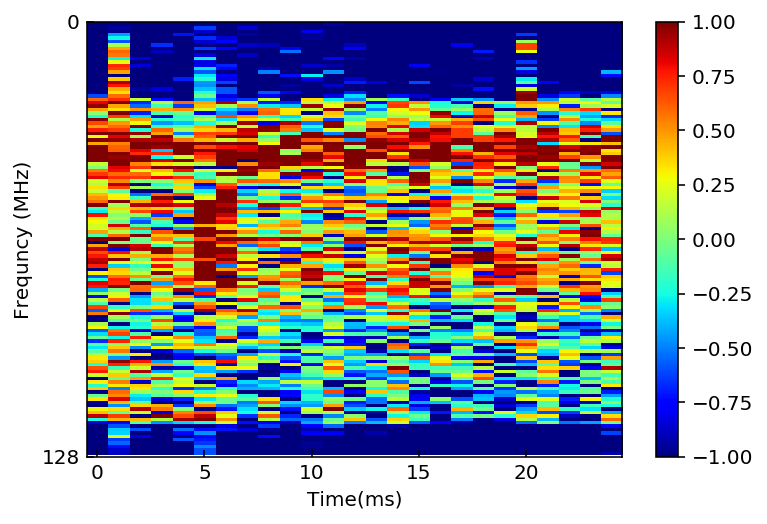

In [98]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
data_array = anom_true[1215].reshape((predict_size, 128)).T
im = axes.imshow(data_array, cmap='jet',vmin=-1, vmax=1,aspect='auto')
axes.tick_params(direction="in")
axes.set_yticks([0, 128])
axes.set_xlabel('Time(ms)', size=10)
axes.set_ylabel('Frequncy (MHz)', size=10)
fig.colorbar(im, ax=axes)

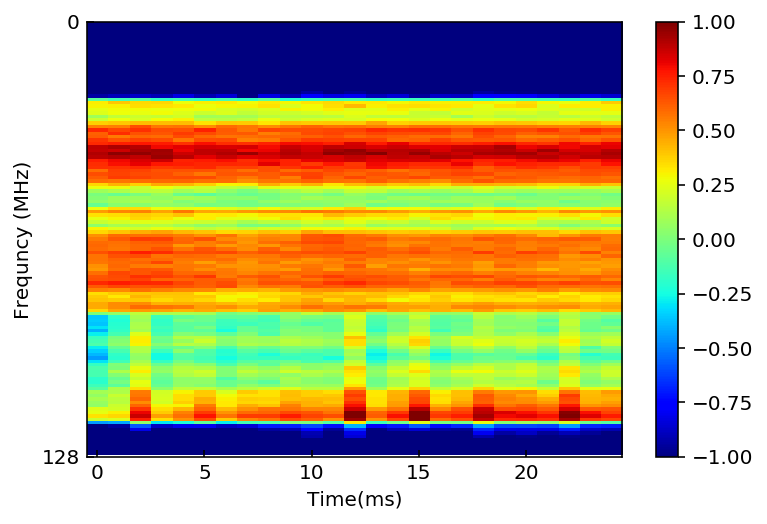

In [99]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
data_array = anom_hat[1215].reshape((predict_size, 128)).T
im = axes.imshow(data_array, cmap='jet',vmin=-1, vmax=1,aspect='auto')
axes.tick_params(direction="in")
axes.set_yticks([0,128])
axes.set_xlabel('Time(ms)', size=10)
axes.set_ylabel('Frequncy (MHz)', size=10)
fig.colorbar(im, ax=axes)

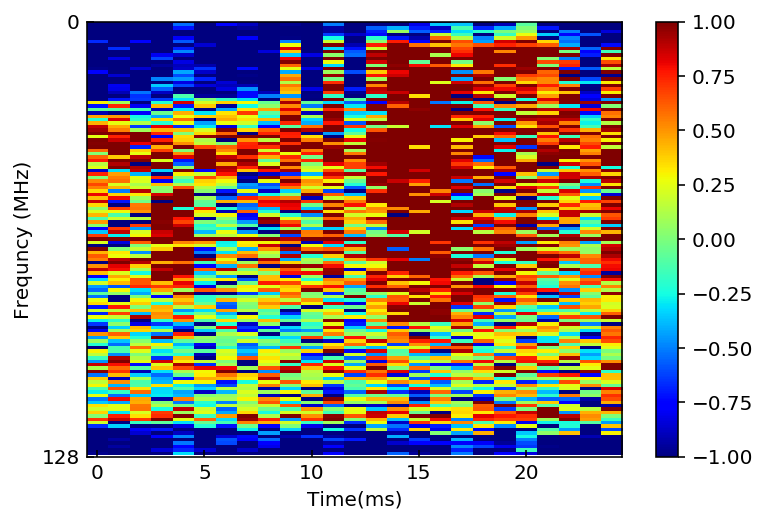

In [84]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
data_array = anom_true[0].reshape((predict_size, 128)).T
im = axes.imshow(data_array, cmap='jet',vmin=-1, vmax=1,aspect='auto')
axes.tick_params(direction="in")
axes.set_yticks([0,128])
axes.set_xlabel('Time(ms)', size=10)
axes.set_ylabel('Frequncy (MHz)', size=10)
fig.colorbar(im, ax=axes)

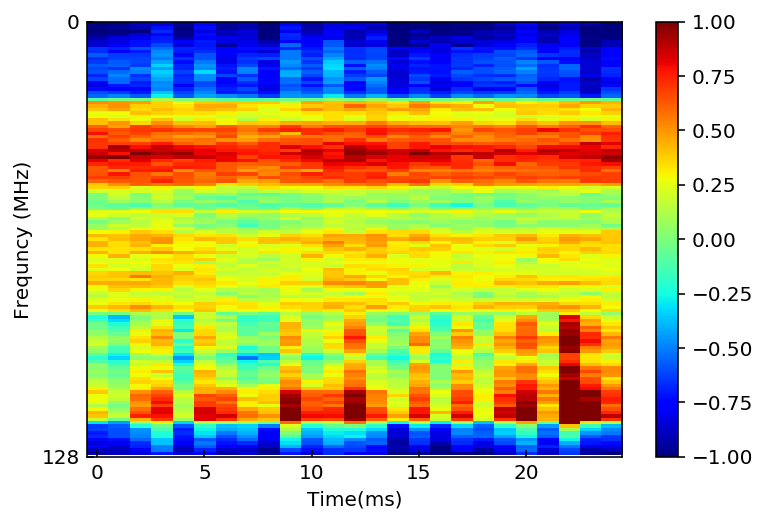

In [85]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
data_array = anom_hat[0].reshape((predict_size, 128)).T
im = axes.imshow(data_array, cmap='jet',vmin=-1, vmax=1,aspect='auto')
axes.tick_params(direction="in")
axes.set_yticks([0,128])
axes.set_xlabel('Time(ms)', size=10)
axes.set_ylabel('Frequncy (MHz)', size=10)
fig.colorbar(im, ax=axes)

In [ ]:
def plot_normalized_batch_spec(plotDict):
    time_step = 1000
    Slen = 128
    image_num = 5
    time_duration = 3 # one image is about 1s, so # of images = time duration (s)
    start_point = 12800
    line_count = 0

    for time in range(0, time_duration):
            fig, axes = plt.subplots(image_num, 1, sharex=True, sharey=True)
            for index in range(0,image_num):
                    data = []
                    fid = open(plotDict[index][0] + '.txt','r')
                    for i in range(0,start_point):
                        fid.readline()
                    for i in range(0,time_step):
                        line = fid.readline()
                        line_count += 1
                        amplitude = line.split()
                        current_data = [float(i) for i in amplitude]
                        mean_data= np.mean(current_data)
                        std_data = np.std(current_data)
                        normalized_data = standard(current_data, mean_data, std_data)
                        data += normalized_data

                    data_array = np.array(data).reshape((time_step,Slen)).T
                    im = axes[index].imshow(data_array,cmap='jet',vmin=-1,vmax=1,aspect='auto')
                    axes[index].set_title(plotDict[index][1])
                    axes[index].tick_params(direction="in")
                    axes[index].set_yticks([0,128])
            axes[image_num-1].set_xlabel('Time(ms)',size=16)
            axes[2].set_ylabel('Frequncy (MHz)', size=16)
            ax2_v = axes[2].twinx()
            ax2_v.yaxis.set_label_position("right")
            ax2_v.set_ylabel('FFT Amp. (dBm)', size=16, labelpad = 70)
            plt.setp(ax2_v.get_yticklabels(), visible=False)
            xtick = [i*5 for i in [0,40,80,120,160,200]]
            plt.setp(axes, xticks=xtick, xticklabels=[int(i*0.25) for i in xtick],
                     yticks=[0,128], yticklabels=['0','5'])
            plt.subplots_adjust(hspace=0.7)
            fig.colorbar(im, ax=axes.ravel().tolist())
            fig.savefig('normalized' + str(time+1) + '00ms.png', dpi=1200)
            plt.show()
            plt.close(fig)


In [ ]:

PlotDict = [['1518591120_880M_5m_ap','Normal BS'], 
            ['1518591120_1580413698_880M_5m_ap', 'FBS'],
            ['1518591120_880M_5m_sigOver_ap', 'CSO'],
            ['1518591120_880M_5m_relay_ap', 'MitM'],
            ['0208_880M_qpsk_searle_i1_ap','Jamming']]

plot_normalized_batch_spec(PlotDict)